In [1]:
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from collections import Counter, defaultdict
import json, csv
import numpy as np
import xmltodict
from sklearn.dummy import DummyClassifier
import random
from sklearn.metrics import precision_recall_fscore_support

import os
from statistics import mean, stdev
import warnings 
from scipy.stats import ttest_rel, levene
from collections import defaultdict
from typing import List, Dict, Tuple
from scipy import stats
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from rouge_score import rouge_scorer
from scipy.stats import pearsonr

warnings.filterwarnings('ignore') 

# All analysis on Gemini1.5, 5-s, Task2

In [32]:
all_cases = pd.read_csv('qualitative_analysis/error_analysis_t2.csv')

In [33]:
topic_rouge = []

for topic in all_cases['dataset'].unique():
    df = all_cases[all_cases['dataset'] == topic]
    topic_rouge.append({
        'dataset': topic,
        'avg_rougeL': df['rouge_score'].mean()
    })

topic_rouge_df = pd.DataFrame(topic_rouge).round(3)
topic_rouge_df

,dataset,avg_rougeL
0,abortion,0.631
1,gayRights,0.590
2,marijuana,0.569
3,obama,0.620


In [34]:
stance_rouge = []

for stance in ['Pro', 'Con']:
    df = all_cases[all_cases['stance'] == stance]
    stance_rouge.append({
        'stance': stance,
        'avg_rougeL': df['rouge_score'].mean()
    })

stance_rouge_df = pd.DataFrame(stance_rouge).round(3)
stance_rouge_df

,stance,avg_rougeL
0,Pro,0.590
1,Con,0.624


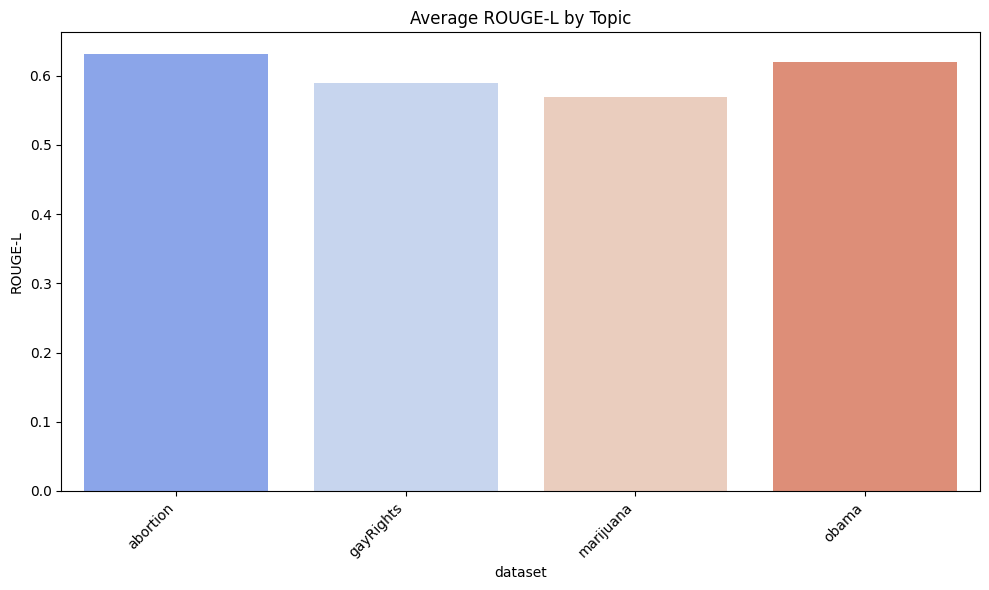

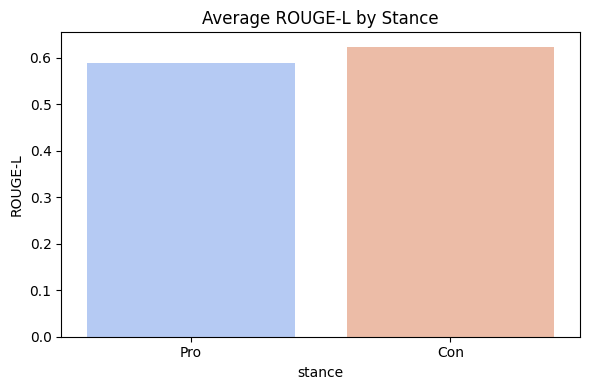

In [35]:
plt.figure(figsize=(10, 6))
sns.barplot(data=topic_rouge_df, x='dataset', y='avg_rougeL', palette='coolwarm')
plt.title('Average ROUGE-L by Topic')
plt.ylabel('ROUGE-L')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=stance_rouge_df, x='stance', y='avg_rougeL', palette='coolwarm')
plt.title('Average ROUGE-L by Stance')
plt.ylabel('ROUGE-L')
plt.tight_layout()
plt.show()

In [36]:
all_cases = all_cases[all_cases['argument'] != 'Others']
all_cases

,dataset,split,id,gold,pred,rouge_score,argument,stance,comment
0,abortion,1,ab1,Making abortions illegal has been shown to for...,3. No one is forcing anyone to have an abortio...,0.3386,Abortion is a woman’s right.,Pro,Once again... 1. In all instances abortion is...
1,abortion,1,ab1,In all instances abortion is legal except extr...,1. In all instances abortion is legal except e...,0.5429,"A fetus is not a human yet, so it's okay to ab...",Pro,Once again... 1. In all instances abortion is...
3,abortion,1,ab10,"when a woman chooses to abort the fetus, she i...",Thus killing a human being.,0.3448,Abortion kills a life.,Con,Try pricking a newborn with a needle and see i...
4,abortion,1,ab10,humans maybe parasites for the first nine mont...,"It is both, humans maybe parasites for the fir...",0.9143,An unborn baby is a human and has the right to...,Con,Try pricking a newborn with a needle and see i...
5,abortion,1,ab100,There are other ways the child can get taken c...,There are other ways the child can get taken c...,1.0000,Put baby up for adoption.,Con,There are other ways the child can get taken c...
...,...,...,...,...,...,...,...,...,...
14134,obama,5,oba96,Obama would destroy the economy.,Obama would destroy the economy.,1.0000,Destroyed our economy.,Con,Obama would destroy the economy. I've already ...
14135,obama,5,oba97,"He's a people president, he actually cares abo...","He's a people president, he actually cares abo...",1.0000,Has qualities of a good leader.,Pro,"He's a people president, he actually cares abo..."
14137,obama,5,oba99,War in the Middle East. so your mad that he's...,War in the Middle East. so your mad that he's...,1.0000,Ending the wars.,Pro,War in the Middle East. so your mad that he's...
14138,obama,5,oba99,"Atleast he's trying to fix the economy, all Bu...","Atleast he's trying to fix the economy, all Bu...",1.0000,Fixed the economy.,Pro,War in the Middle East. so your mad that he's...


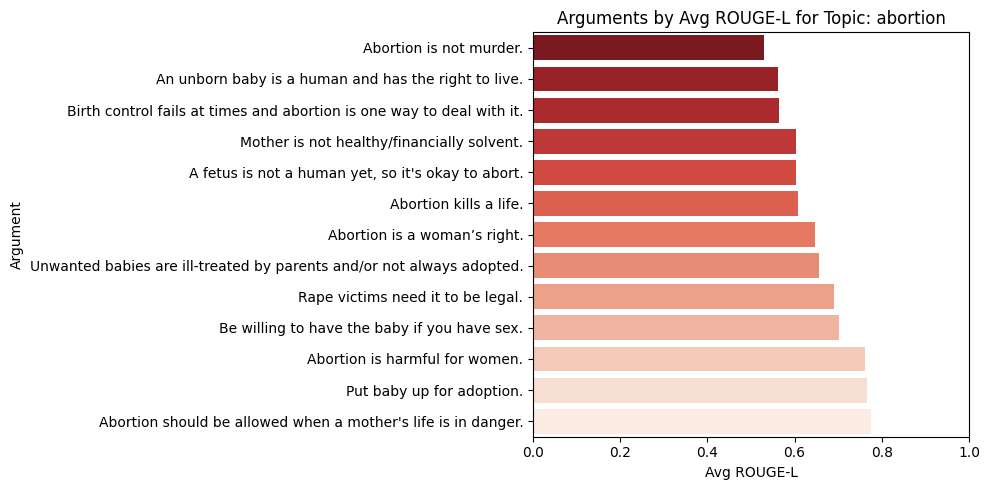

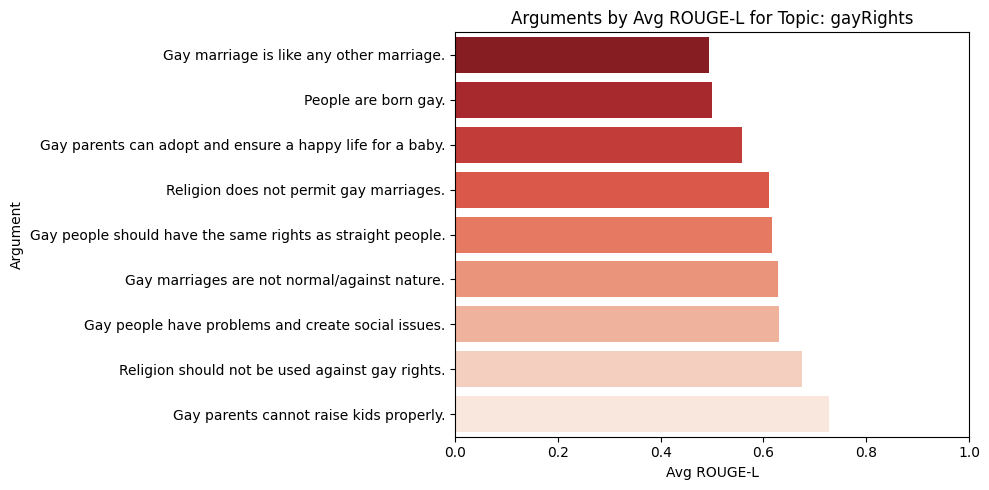

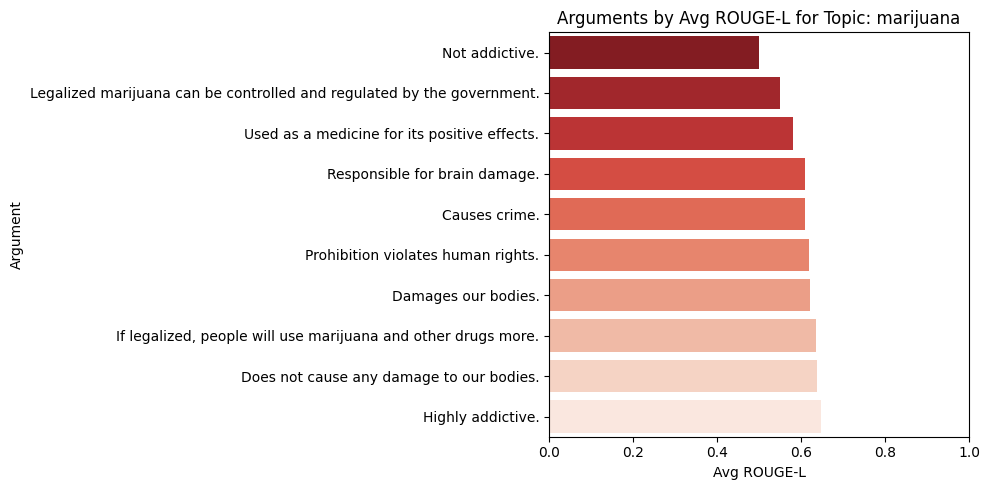

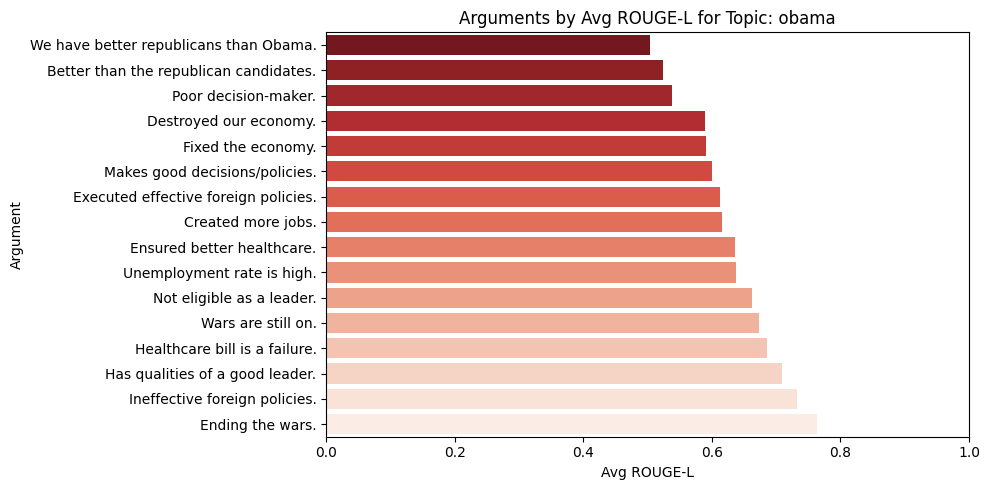

In [37]:
avg_rouge_per_argument = (
    all_cases.groupby(['dataset', 'argument'])['rouge_score']
    .mean()
    .reset_index()
    .rename(columns={'rouge_score': 'avg_rougeL'})
)

N = 5  
worst_arguments_per_topic = []

for topic in avg_rouge_per_argument['dataset'].unique():
    topic_df = avg_rouge_per_argument[avg_rouge_per_argument['dataset'] == topic]
    
    worst_args = topic_df.sort_values(by='avg_rougeL')
    
    worst_args['topic'] = topic
    worst_arguments_per_topic.append(worst_args)

worst_arguments_per_topic_df = pd.concat(worst_arguments_per_topic)

for topic in worst_arguments_per_topic_df['topic'].unique():
    df = worst_arguments_per_topic_df[worst_arguments_per_topic_df['topic'] == topic]
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=df, x='avg_rougeL', y='argument', palette='Reds_r')
    plt.title(f'Arguments by Avg ROUGE-L for Topic: {topic}')
    plt.xlabel('Avg ROUGE-L')
    plt.ylabel('Argument')
    plt.xlim(0, 1)  # ROUGE-L scores are between 0 and 1
    plt.tight_layout()
    plt.show()

## Quantitative analysis

In [38]:
### 1. Effect of Argument Frequency on Accuracy

arg_counts = all_cases['argument'].value_counts().reset_index()
arg_counts.columns = ['argument', 'frequency']

arg_accuracy = all_cases.groupby('argument').apply(
    lambda x: (x['gold'] == x['pred']).mean()
).reset_index()
arg_accuracy.columns = ['argument', 'accuracy']

arg_analysis = pd.merge(arg_counts, arg_accuracy, on='argument')

corr, p_value = pearsonr(arg_analysis['frequency'], arg_analysis['accuracy'])
print(f"Correlation between argument frequency and accuracy: {corr:.4f} (p={p_value:.4f})")

Correlation between argument frequency and accuracy: -0.2476 (p=0.0897)


- Weak positive effect of frequency

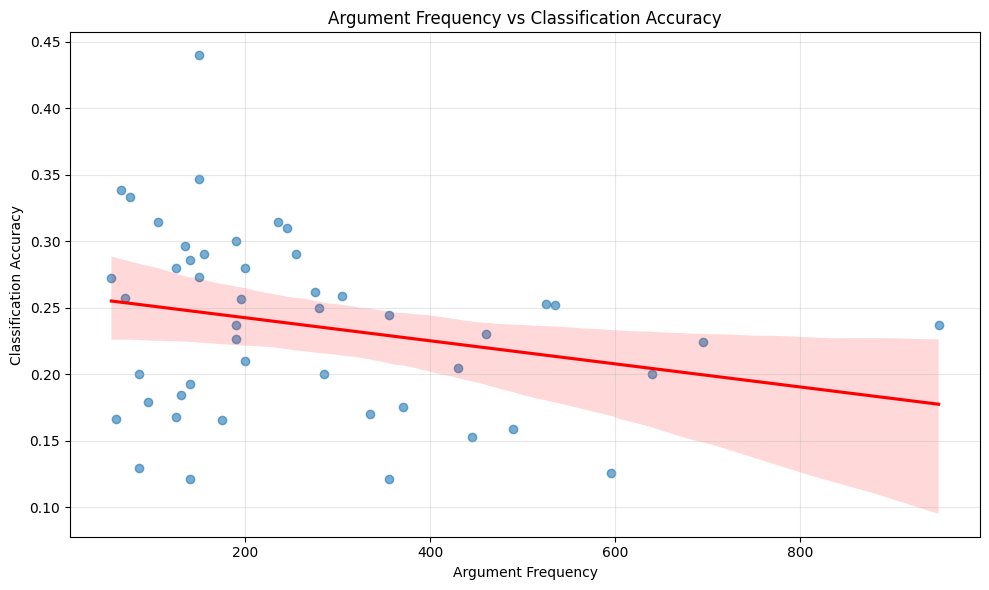

In [39]:
plt.figure(figsize=(10, 6))
sns.regplot(
    data=arg_analysis, 
    x='frequency', 
    y='accuracy', 
    scatter_kws={'alpha':0.6}, 
    line_kws={'color':'red'}
)
plt.xlabel('Argument Frequency')
plt.ylabel('Classification Accuracy')
plt.title('Argument Frequency vs Classification Accuracy')
plt.grid(True, alpha=0.3)
plt.tight_layout()

In [40]:
### 2. Single Argument Performance

worst_args = arg_analysis.sort_values('accuracy').head(10)
best_args = arg_analysis.sort_values('accuracy', ascending=False).head(10)


arg_topics = all_cases.groupby('argument')['dataset'].first().reset_index()
arg_analysis = pd.merge(arg_analysis, arg_topics, on='argument')

topic_counts = all_cases['dataset'].value_counts().reset_index()
topic_counts.columns = ['dataset', 'topic_total']

arg_analysis = pd.merge(arg_analysis, topic_counts, on='dataset')

# Calculate proportion
arg_analysis['topic_proportion'] = arg_analysis['frequency'] / arg_analysis['topic_total']

worst_args = arg_analysis.sort_values('accuracy').head(10)[['argument', 'accuracy', 'frequency', 'topic_proportion', 'dataset']]
best_args = arg_analysis.sort_values('accuracy', ascending=False).head(10)[['argument', 'accuracy', 'frequency', 'topic_proportion', 'dataset']]

print("Most Incorrectly Classified Arguments:")
print(worst_args)
print("\nMost Correctly Classified Arguments:")
print(best_args)

Most Incorrectly Classified Arguments:
                                             argument  accuracy  frequency  \
11           Gay marriage is like any other marriage.  0.121127        355   
32  If legalized, people will use marijuana and ot...  0.121429        140   
3                                      Not addictive.  0.126050        595   
42                            Abortion is not murder.  0.129412         85   
8                                People are born gay.  0.152809        445   
6   An unborn baby is a human and has the right to...  0.159184        490   
27                     Makes good decisions/policies.  0.165714        175   
46  Birth control fails at times and abortion is o...  0.166667         60   
37               Executed effective foreign policies.  0.168000        125   
13             Better than the republican candidates.  0.170149        335   

    topic_proportion    dataset  
11          0.106447  gayRights  
32          0.046434  marijuana  


- Model tends to underpredict

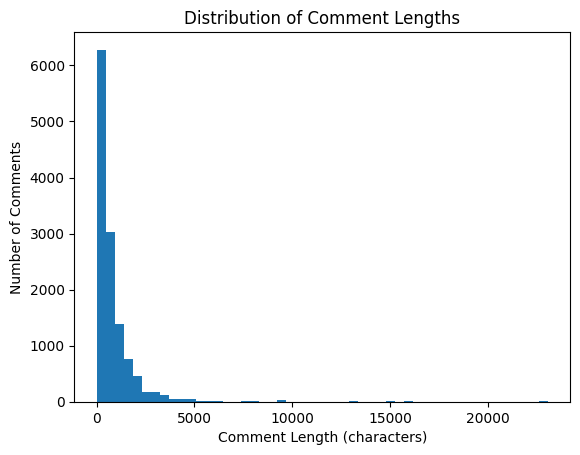

In [43]:
all_cases['comment_length'] = all_cases['comment'].str.len()

plt.hist(all_cases['comment_length'], bins=50)
plt.xlabel('Comment Length (characters)')
plt.ylabel('Number of Comments')
plt.title('Distribution of Comment Lengths')
plt.show()

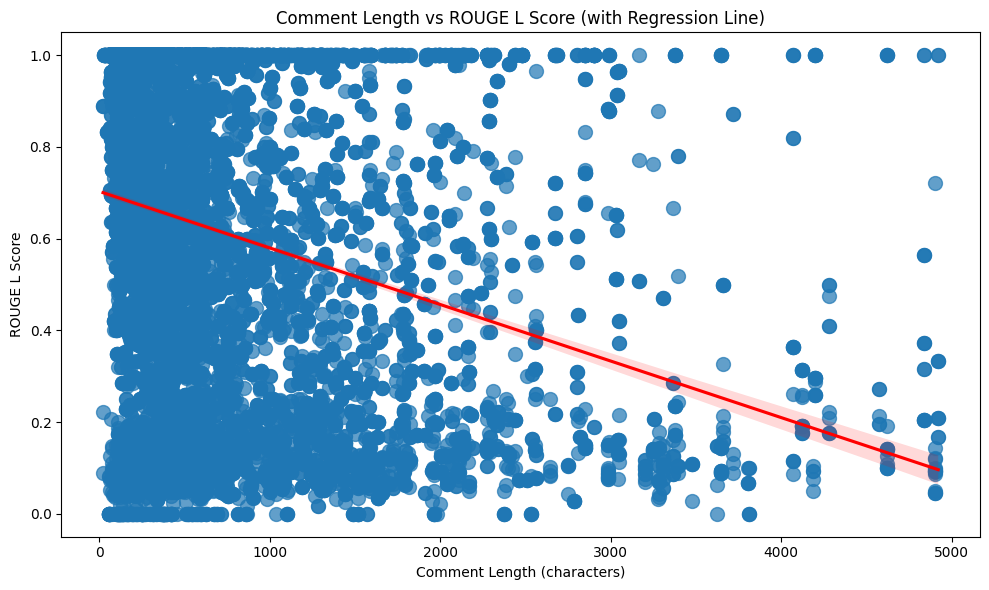

Pearson correlation: -0.2750991179096849
P-value: 4.65e-216


In [47]:
all_cases["comment_length"] = all_cases["comment"].str.len()

all_cases = all_cases[all_cases['comment_length'] <= 5000]

plt.figure(figsize=(10, 6))
sns.regplot(data=all_cases, x="comment_length", y="rouge_score", scatter_kws={'s': 100, 'alpha': 0.7}, line_kws={"color": "red"})
plt.title("Comment Length vs ROUGE L Score (with Regression Line)")
plt.xlabel("Comment Length (characters)")
plt.ylabel("ROUGE L Score")
plt.tight_layout()
plt.show()

corr, p_value = pearsonr(all_cases['comment_length'], all_cases['rouge_score'])

print(f"Pearson correlation: {corr}")
print(f"P-value: {p_value:.2e}")

# Qualitative analysis

In [56]:
error_samples = all_cases[all_cases['rouge_score'] >= 0.8].groupby('dataset').apply(
    lambda x: x.sample(min(8, len(x)))
).reset_index(drop=True)

os.makedirs("qualitative_analysis", exist_ok=True)
error_samples.to_csv("qualitative_analysis/error_samples_rouge_l_more_than_0.8.csv", index=False, encoding='utf-8')